## import data

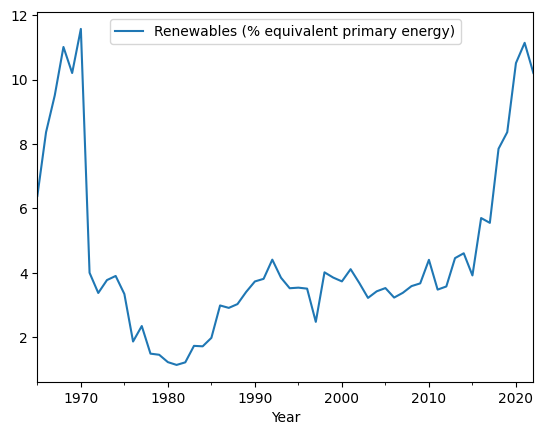

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('dataset/renewable-share-energy.csv')
df = df[df['Entity'] == 'Indonesia']
df = df.drop('Code', axis=1)
df.reset_index(drop=True, inplace=True)
#df = df.fillna(0)
df = df.drop('Entity', axis=1)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df = df.set_index('Year')['Renewables (% equivalent primary energy)']
df = pd.DataFrame(df)
df.plot()
plt.show()

## Stationer

In [14]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
def check_stationarity(data):
    result = adfuller(data.dropna())  # dropna() handles missing values
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\	%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("Fall to reject the null hypothesis. Data is not stationary")

check_stationarity(df)

ADF Statistic: -2.338355
p-value: 0.159896
Critical Values:
\	1%: -3.558
\	5%: -2.917
\	10%: -2.596
Fall to reject the null hypothesis. Data is not stationary


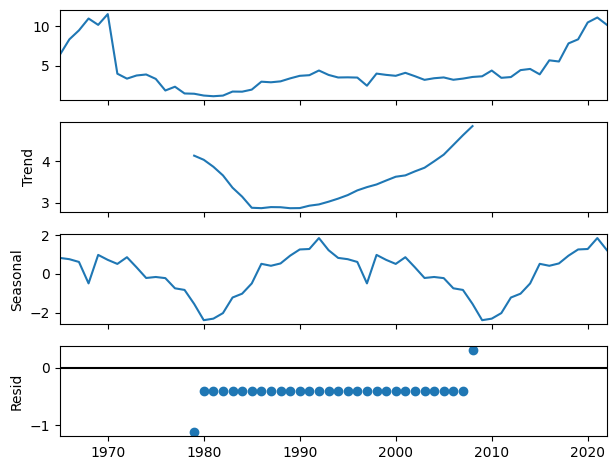

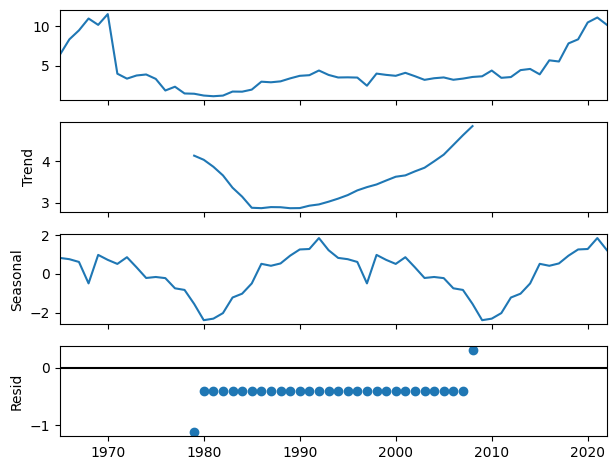

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df, model='additive', period=29)
decompose.plot()

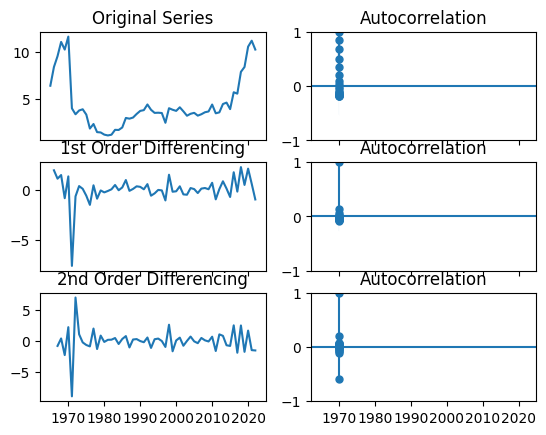

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df);axes[0,0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(df.diff());axes[1,0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[1,1])
# 2nd Differencing
axes[2, 0].plot(df.diff().diff());axes[2,0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), ax=axes[2,1])

plt.show()

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
train, test = train_test_split(df, test_size=0.2, shuffle=False)

print('Data split into training and testing sets.')
print('Training set size:', len(train))
print('Testing set size:', len(test))

Data split into training and testing sets.
Training set size: 46
Testing set size: 12


## Search p,d,q

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=156.722, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=158.426, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=158.463, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=154.772, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=160.010, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.167 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -76.386
Date:                Sun, 12 May 2024   AIC                            154.772
Time:                        11:49:38   BIC                            156.579
Sample:                    01-01-1965   HQIC                           155.445
                         - 01-01-2010                                         
Co

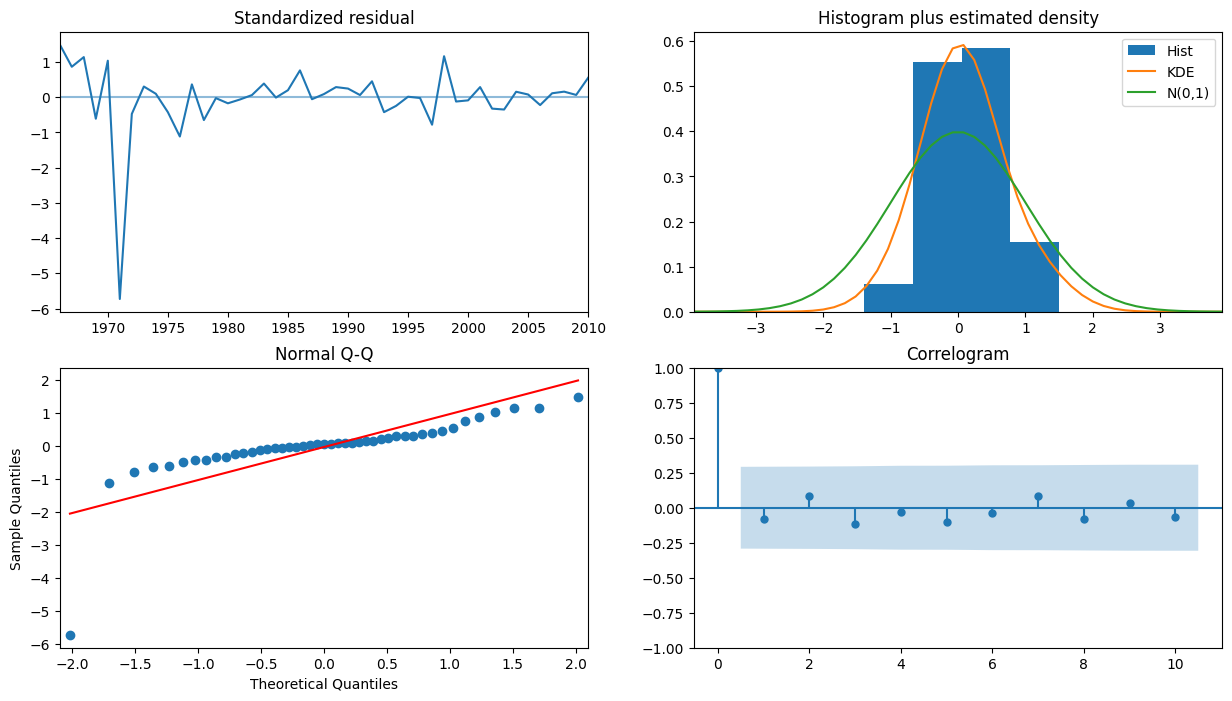

In [22]:
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [23]:
model_autoARIMA

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

## Arima fit

                                          SARIMAX Results                                           
Dep. Variable:     Renewables (% equivalent primary energy)   No. Observations:                   46
Model:                                                ARIMA   Log Likelihood                -105.828
Date:                                      Sun, 12 May 2024   AIC                            215.656
Time:                                              11:51:25   BIC                            219.313
Sample:                                          01-01-1965   HQIC                           217.026
                                               - 01-01-2010                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9269      0.635  

c:\Users\M S I\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\M S I\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\M S I\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


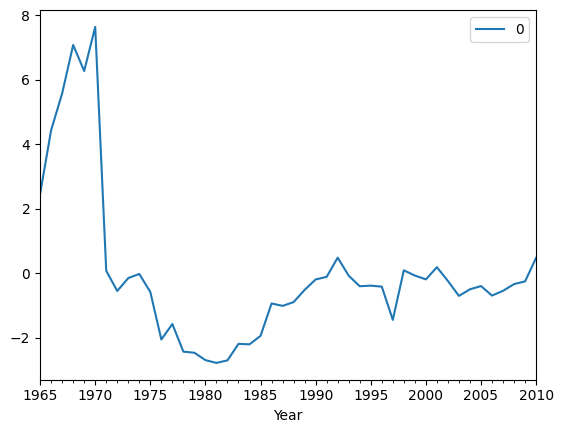

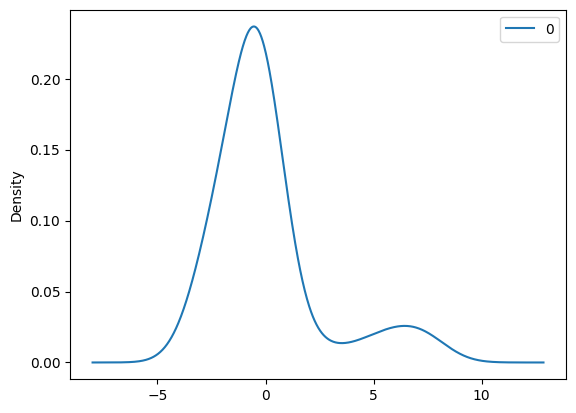

               0
count  46.000000
mean    0.000005
std     2.441610
min    -2.786248
25%    -0.996800
50%    -0.403144
75%    -0.037095
max     7.643741


In [31]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from matplotlib import pyplot

model = ARIMA(train, order=(0,0,0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

# summary stats of residuals
print(residuals.describe())

## Forecast

In [32]:
forecast = pd.DataFrame(model_fit.forecast(steps=12))
forecast.columns = ['Renewables (% equivalent primary energy)']
forecast.index.name = 'Year'
forecast

,Renewables (% equivalent primary energy)
Year,
2011-01-01,3.926929
2012-01-01,3.926929
2013-01-01,3.926929
2014-01-01,3.926929
2015-01-01,3.926929
...,...
2018-01-01,3.926929
2019-01-01,3.926929
2020-01-01,3.926929


<function matplotlib.pyplot.show(close=None, block=None)>

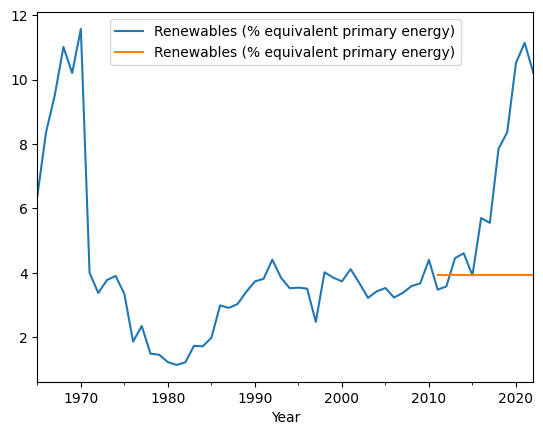

In [33]:
data = pd.concat([df, forecast], axis=1)
data
data.plot()
plt.show

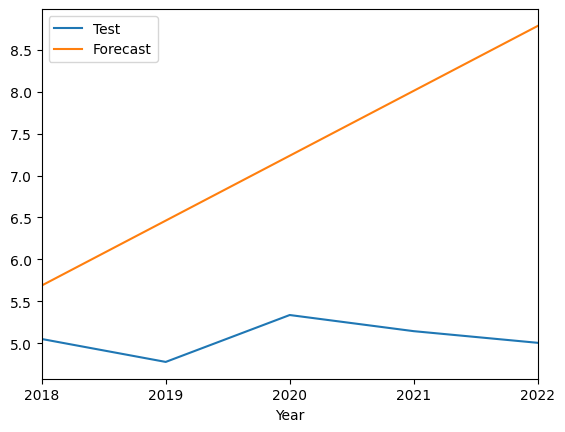

In [10]:
compare = pd.concat([test, forecast], axis=1)
compare.columns = ['Test', 'Forecast']
compare.plot()
plt.show()

import matplotlib.pyplot as plt
compare.plot()
plt.show()

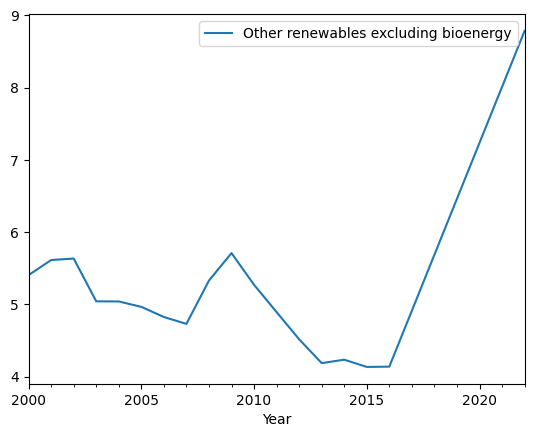

In [11]:
data = pd.concat([train, forecast])
data.plot()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Menghitung metrik evaluasi
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 2.174591179342601
Mean Squared Error (MSE): 5.87581494600772
Root Mean Squared Error (RMSE): 2.4240080334041223
